In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import mean_squared_error as mse
import pickle
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score



warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df_houses = pd.read_parquet('ML_Dataset.parquet', engine='pyarrow')

In [170]:
df_houses.columns

Index(['geometry', 'job_density', 'distance_to_nearest_station',
       'nearest_station_name', 'departures_per_hour', 'distance_to_job_center',
       'latitude', 'longitude', 'propertyType', 'energyClass', 'priceCash',
       'selfsale', 'rooms', 'size', 'lotSize', 'buildYear', 'city', 'zipCode',
       'area', 'exp', 'basementSize', 'businessArea', 'nonPremiumDiscrete',
       'cleanStreet', 'municipality'],
      dtype='object')

In [25]:
models = {}
all_results = {}

In [5]:
all_results

{'run_1': {'mean_fit_time': array([118.0771538 ,  77.50656116,  66.43088484, 134.17232144]),
  'std_fit_time': array([37.42849123,  3.78894031,  2.34764194, 38.13280928]),
  'mean_score_time': array([2.27848375, 2.20254362, 2.27749908, 2.25473213]),
  'std_score_time': array([0.00274098, 0.00832903, 0.00215733, 0.02227831]),
  'param_elasticnet__l1_ratio': masked_array(data=[0.29292929292929293, 0.7676767676767677,
                     0.6363636363636365, 0.24242424242424243],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_elasticnet__alpha': masked_array(data=[0.040902747309136206, 0.03870378545275976,
                     0.04048487290904394, 0.037709902220567484],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'elasticnet__l1_ratio': 0.29292929292929293,
    'elasticnet__alpha': 0.040902747309136206},
   {'elasticnet__l1_ratio': 0.7676767676767677,

In [33]:
selected_columns = [
        'job_density', 'distance_to_nearest_station', 'departures_per_hour', 'distance_to_job_center', 
        'propertyType', 'energyClass', 'rooms', 'size', 
        'lotSize', 'buildYear', 'exp', 'basementSize', 'municipality'
    ]
X = df_houses[selected_columns]


y=df_houses['priceCash']/1000000

In [34]:
X['municipality'] = X['municipality'].astype('category')
X['propertyType'] = X['propertyType'].astype('category')

C:\Users\Tobias Thiim\AppData\Local\Temp\ipykernel_40956\3271216660.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['municipality'] = X['municipality'].astype('category')
C:\Users\Tobias Thiim\AppData\Local\Temp\ipykernel_40956\3271216660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['propertyType'] = X['propertyType'].astype('category')


In [35]:
X = pd.get_dummies(X, drop_first=True)

In [36]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=(1 / 3), random_state=161193)

In [37]:
# Define the mean and standard deviation
mean_lambda = 0.040
std_dev = 0.02  # Standard deviation, adjust for how spread out you want the values

# Generate 4 random lambda values from a normal distribution
lambdas = np.random.normal(loc=mean_lambda, scale=std_dev, size=100)

# Ensure that the values are positive (since lambda should be positive)
lambdas = np.abs(lambdas)

In [38]:
# Set up the pipeline
pipe_el = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False), 
    StandardScaler(),
    ElasticNet(random_state=161193)
)

# Set up the randomized search with verbosity
rs = RandomizedSearchCV(estimator=pipe_el, 
                        param_distributions={'elasticnet__alpha': lambdas,
                                             'elasticnet__l1_ratio': np.linspace(0, 1, 100)},
                        scoring='neg_mean_squared_error', 
                        cv=5,
                        n_iter=35,  # Number of parameter settings that are sampled
                        random_state=161193,  # For reproducibility
                        verbose=3)  # verbose=3 provides detailed output


In [40]:
models['med_egne_samme_lambda_35_ny_data'] = rs.fit(X_dev, y_dev)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5] END elasticnet__alpha=0.043840898137199075, elasticnet__l1_ratio=0.29292929292929293;, score=-2.817 total time= 1.5min
[CV 2/5] END elasticnet__alpha=0.043840898137199075, elasticnet__l1_ratio=0.29292929292929293;, score=-1.715 total time= 1.1min
[CV 3/5] END elasticnet__alpha=0.043840898137199075, elasticnet__l1_ratio=0.29292929292929293;, score=-2.361 total time= 1.1min
[CV 4/5] END elasticnet__alpha=0.043840898137199075, elasticnet__l1_ratio=0.29292929292929293;, score=-3.155 total time= 1.8min
[CV 5/5] END elasticnet__alpha=0.043840898137199075, elasticnet__l1_ratio=0.29292929292929293;, score=-2.427 total time= 1.2min
[CV 1/5] END elasticnet__alpha=0.034386226663064394, elasticnet__l1_ratio=0.7676767676767677;, score=-2.877 total time= 1.3min
[CV 2/5] END elasticnet__alpha=0.034386226663064394, elasticnet__l1_ratio=0.7676767676767677;, score=-1.871 total time= 1.3min
[CV 3/5] END elasticnet__alpha=0.03438622666

In [41]:
#opdater denne, hvis du kører modellen igen

all_results['med_egne_samme_lambda_35_ny_data'] = rs.cv_results_


In [43]:
# Assuming you have run RandomizedSearchCV and stored the results in all_results['run_1']
cv_results_med_egne_samme_lambda_35_ny_data = all_results['med_egne_samme_lambda_35_ny_data']

# Loop through each parameter combination and print details
for i in range(len(cv_results_med_egne_samme_lambda_35_ny_data['mean_test_score'])):
    alpha = cv_results_med_egne_samme_lambda_35_ny_data['param_elasticnet__alpha'][i]  # Lambda (alpha) value
    l1_ratio = cv_results_med_egne_samme_lambda_35_ny_data['param_elasticnet__l1_ratio'][i]  # L1 ratio value
    
    # Mean cross-validated negative MSE for the validation set
    mean_mse_val = cv_results_med_egne_samme_lambda_35_ny_data['mean_test_score'][i]
    
    # Calculate RMSE for validation set
    rmse_val = np.sqrt(-mean_mse_val)
    
    # If you have included 'return_train_score=True' in your GridSearchCV or RandomizedSearchCV, 
    # you can also access training scores:
    if 'mean_train_score' in cv_results_med_egne_samme_lambda_35_ny_data:
        mean_mse_train = cv_results_med_egne_samme_lambda_35_ny_data['mean_train_score'][i]
        rmse_train = np.sqrt(-mean_mse_train)
    else:
        rmse_train = "Training scores not available (return_train_score=False)"
    
    # Print the details
    print(f"Iteration {i+1}:")
    print(f"Lambda (alpha): {alpha}")
    print(f"L1 Ratio: {l1_ratio}")
    print(f"Validation RMSE: {rmse_val}")
    print(f"Training RMSE: {rmse_train}")
    print("-" * 30)


Iteration 1:
Lambda (alpha): 0.043840898137199075
L1 Ratio: 0.29292929292929293
Validation RMSE: 1.579560377548304
Training RMSE: Training scores not available (return_train_score=False)
------------------------------
Iteration 2:
Lambda (alpha): 0.034386226663064394
L1 Ratio: 0.7676767676767677
Validation RMSE: 1.5799286794484246
Training RMSE: Training scores not available (return_train_score=False)
------------------------------
Iteration 3:
Lambda (alpha): 0.01786891667676573
L1 Ratio: 0.6363636363636365
Validation RMSE: 1.5727729066692497
Training RMSE: Training scores not available (return_train_score=False)
------------------------------
Iteration 4:
Lambda (alpha): 0.05545887978713711
L1 Ratio: 0.24242424242424243
Validation RMSE: 1.5803801738193397
Training RMSE: Training scores not available (return_train_score=False)
------------------------------
Iteration 5:
Lambda (alpha): 0.021579920973232403
L1 Ratio: 0.7676767676767677
Validation RMSE: 1.5852193092208906
Training RMSE:

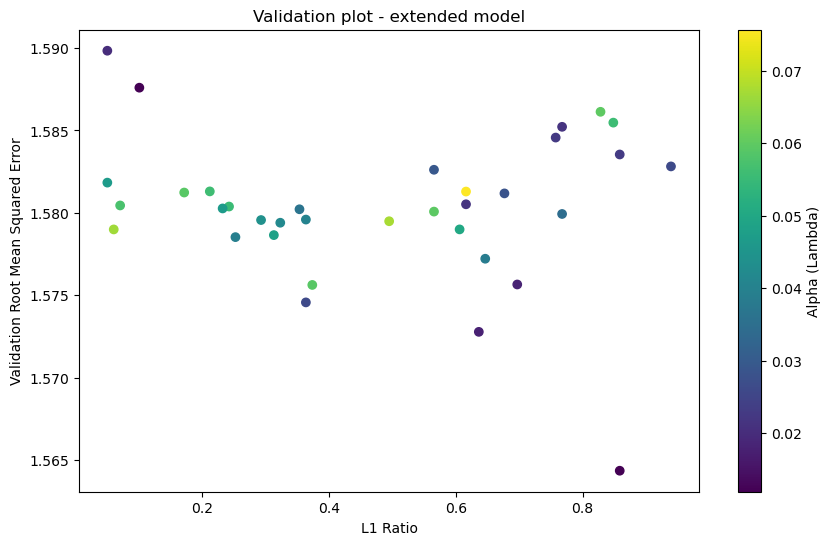

In [74]:
#Plot the rmse with ratio and and alphas

# Extract relevant fields from cv_results_
alphas = cv_results_med_egne_samme_lambda_35_ny_data['param_elasticnet__alpha'].data  # Extract lambda values
l1_ratios = cv_results_med_egne_samme_lambda_35_ny_data['param_elasticnet__l1_ratio'].data  # Extract l1 ratio values
mean_test_scores = cv_results_med_egne_samme_lambda_35_ny_data['mean_test_score']  # Extract mean test scores (negative MSE)

# Convert negative MSE to RMSE
rmse_scores = np.sqrt(-mean_test_scores)

# Plotting the validation curve
plt.figure(figsize=(10, 6))
plt.scatter(l1_ratios, rmse_scores, c=alphas, cmap='viridis', marker='o')
plt.colorbar(label='Alpha (Lambda)')
plt.title('Validation plot - extended model')
plt.xlabel('L1 Ratio')
plt.ylabel('Validation Root Mean Squared Error')
plt.show()

In [70]:
best_index = np.argmax(cv_results_med_egne_samme_lambda_35_ny_data['mean_test_score'])  # mean_test_score is negative MSE

# Retrieve the optimal alpha (lambda) and l1_ratio
optimal_alpha_med_egne = cv_results_med_egne_samme_lambda_35_ny_data['param_elasticnet__alpha'][best_index]
optimal_l1_ratio_med_egne = cv_results_med_egne_samme_lambda_35_ny_data['param_elasticnet__l1_ratio'][best_index]

# Convert the best mean_test_score (which is negative MSE) to positive RMSE
optimal_rmse = np.sqrt(-cv_results_med_egne_samme_lambda_35_ny_data['mean_test_score'][best_index])

print(f"Optimal Alpha (Lambda) for run 10: {optimal_alpha_med_egne}")
print(f"Optimal L1 Ratio for run 10: {optimal_l1_ratio_med_egne}")
print(f"Optimal RMSE for run 10: {optimal_rmse}")

Optimal Alpha (Lambda) for run 10: 0.011999407245170977
Optimal L1 Ratio for run 10: 0.8585858585858587
Optimal RMSE for run 10: 1.5643432812959832


In [100]:
# Refit the model on the entire development dataset with the optimal hyperparameters from run 4
model_egene = ElasticNet(alpha=optimal_alpha_med_egne, l1_ratio=optimal_l1_ratio, random_state=161193)
el_model_egene = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False), 
    StandardScaler(),
    model_egene
)

# Fit the model to the entire development dataset
el_model_egene.fit(X_dev, y_dev)

# Apply the model to the test data
y_test_pred_model_egne = el_model_egene.predict(X_test)

# Evaluate performance on the test data
test_rmse_uden_egne = np.sqrt(mse(y_test, y_test_pred_model_egne))
print(f"Test RMSE for the model from run with egne: {test_rmse_uden_egne}")

Test RMSE for the model from run with egne: 2.1092555376189623


In [58]:
# Calculate R-squared
r_squared = r2_score(y_test, y_test_pred_model_egne)
print(f"R-squared: {r_squared}")

R-squared: 0.7738396105665797


In [101]:

# Extract the coefficients from the model (after the PolynomialFeatures and StandardScaler)
coefficients = el_model_egene.named_steps['elasticnet'].coef_

# Get the feature names (considering the polynomial features)
poly_features = el_model_egene.named_steps['polynomialfeatures'].get_feature_names_out()

# Create a Series with feature names as index and coefficients as values
coeff_series = pd.Series(coefficients, index=poly_features)

# Sort the coefficients to find the most positive and negative ones
sorted_coeffs = coeff_series.sort_values()

# Top 5 features with the most negative coefficients
top_5_negative_features = sorted_coeffs.head(5)

# Top 5 features with the most positive coefficients
top_5_positive_features = sorted_coeffs.tail(5)

# Print the results
print("Top 5 Features with Negative Sign:")
print(top_5_negative_features)

print("\nTop 5 Features with Positive Sign:")
print(top_5_positive_features)




Top 5 Features with Negative Sign:
exp propertyType_3       -0.576609
exp municipality_846.0   -0.467552
exp propertyType_6       -0.333416
exp municipality_223.0   -0.311508
exp municipality_173.0   -0.286965
dtype: float64

Top 5 Features with Positive Sign:
size propertyType_3    0.392293
rooms exp              0.460995
size lotSize           0.503896
buildYear exp          1.107448
exp                    1.434169
dtype: float64


In [ ]:
plt.rcParams['font.family'] = 'Georgia'


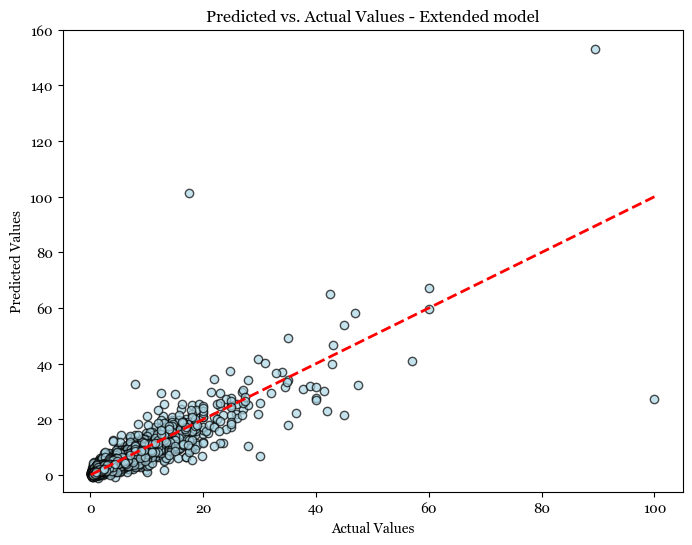

In [95]:
# Plot for the Simple model
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_model_egne, color='lightblue', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)
plt.ylim(-6, 160)  # Manually set ylim
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values - Extended model')
plt.show()



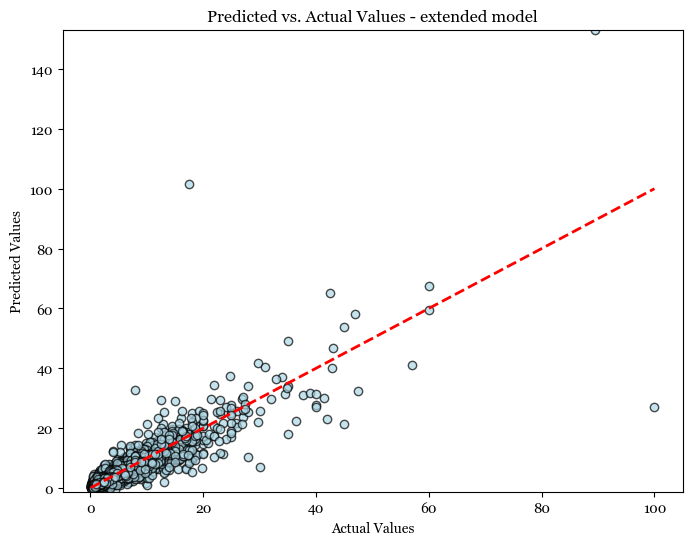

In [84]:
# Plot for the extended model
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_model_egne, color='lightblue', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)
plt.ylim(y_min, y_max)  # Set the common ylim
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values - extended model')
plt.show()


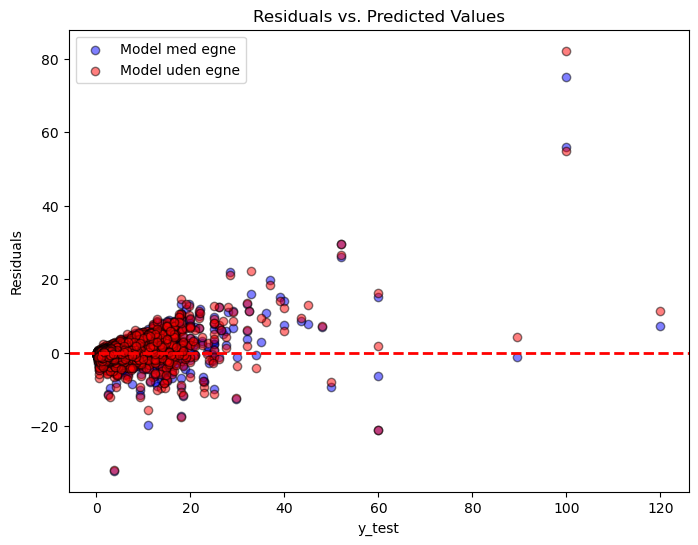

In [134]:
# Calculate residuals
residuals_med_egne = y_test - y_test_pred_best_model_med_egne_nr_10
residuals_uden_egne = y_test - y_test_pred_best_model_run_uden_egne_nr_11

# Plot Residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals_med_egne, color='blue', edgecolor='k', alpha=0.5, label='Model med egne')
plt.scatter(y_test, residuals_uden_egne, color='red', edgecolor='k', alpha=0.5, label='Model uden egne')
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel('y_test')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.legend()
plt.show()

---------------------------------ANDEN RUNDE UDEN EGNE VARIABLE------------------------------------------------------------

In [49]:
selected_columns = [ 
        'propertyType', 'energyClass', 'rooms', 'size', 
        'lotSize', 'buildYear', 'exp', 'basementSize', 'municipality'
    ]
X = df_houses[selected_columns]


y=df_houses['priceCash']/1000000

In [50]:
X['municipality'] = X['municipality'].astype('category')
X['propertyType'] = X['propertyType'].astype('category')

C:\Users\Tobias Thiim\AppData\Local\Temp\ipykernel_40956\3271216660.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['municipality'] = X['municipality'].astype('category')
C:\Users\Tobias Thiim\AppData\Local\Temp\ipykernel_40956\3271216660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['propertyType'] = X['propertyType'].astype('category')


In [51]:
X = pd.get_dummies(X, drop_first=True)

In [52]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=(1 / 3), random_state=161193)

In [19]:
# Define the mean and standard deviation

mean_lambda = 0.04
std_dev = 0.02  # Standard deviation, adjust for how spread out you want the values

# Generate 4 random lambda values from a normal distribution
lambdas = np.random.normal(loc=mean_lambda, scale=std_dev, size=100)

# Ensure that the values are positive (since lambda should be positive)
lambdas = np.abs(lambdas)

In [22]:
models['uden_egne_opdateret_data_samme_lamb_35'] = rs.fit(X_dev, y_dev)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5] END elasticnet__alpha=0.03596108868074345, elasticnet__l1_ratio=0.29292929292929293;, score=-2.972 total time=  44.2s
[CV 2/5] END elasticnet__alpha=0.03596108868074345, elasticnet__l1_ratio=0.29292929292929293;, score=-1.860 total time= 1.1min
[CV 3/5] END elasticnet__alpha=0.03596108868074345, elasticnet__l1_ratio=0.29292929292929293;, score=-2.519 total time= 1.1min
[CV 4/5] END elasticnet__alpha=0.03596108868074345, elasticnet__l1_ratio=0.29292929292929293;, score=-3.276 total time=  53.6s
[CV 5/5] END elasticnet__alpha=0.03596108868074345, elasticnet__l1_ratio=0.29292929292929293;, score=-2.498 total time= 1.1min
[CV 1/5] END elasticnet__alpha=0.017081105949465564, elasticnet__l1_ratio=0.7676767676767677;, score=-2.984 total time= 1.8min
[CV 2/5] END elasticnet__alpha=0.017081105949465564, elasticnet__l1_ratio=0.7676767676767677;, score=-1.941 total time= 1.7min
[CV 3/5] END elasticnet__alpha=0.0170811059494655

NameError: name 'models' is not defined

In [26]:
all_results['uden_egne_opdateret_data_samme_lamb_35'] = rs.cv_results_


In [27]:
# Assuming you have run RandomizedSearchCV and stored the results in all_results['run_1']
cv_result_uden_egne_opdateret_data_samme_lamb_35 = all_results['uden_egne_opdateret_data_samme_lamb_35']

# Loop through each parameter combination and print details
for i in range(len(cv_result_uden_egne_opdateret_data_samme_lamb_35['mean_test_score'])):
    alpha = cv_result_uden_egne_opdateret_data_samme_lamb_35['param_elasticnet__alpha'][i]  # Lambda (alpha) value
    l1_ratio = cv_result_uden_egne_opdateret_data_samme_lamb_35['param_elasticnet__l1_ratio'][i]  # L1 ratio value
    
    # Mean cross-validated negative MSE for the validation set
    mean_mse_val = cv_result_uden_egne_opdateret_data_samme_lamb_35['mean_test_score'][i]
    
    # Calculate RMSE for validation set
    rmse_val = np.sqrt(-mean_mse_val)
    
    # If you have included 'return_train_score=True' in your GridSearchCV or RandomizedSearchCV, 
    # you can also access training scores:
    if 'mean_train_score' in cv_result_uden_egne_opdateret_data_samme_lamb_35:
        mean_mse_train = cv_result_uden_egne_opdateret_data_samme_lamb_35['mean_train_score'][i]
        rmse_train = np.sqrt(-cv_result_uden_egne_opdateret_data_samme_lamb_35)
    else:
        rmse_train = "Training scores not available (return_train_score=False)"
    
    # Print the details
    print(f"Iteration {i+1}:")
    print(f"Lambda (alpha): {alpha}")
    print(f"L1 Ratio: {l1_ratio}")
    print(f"Validation RMSE: {rmse_val}")
    print(f"Training RMSE: {rmse_train}")
    print("-" * 30)

Iteration 1:
Lambda (alpha): 0.03596108868074345
L1 Ratio: 0.29292929292929293
Validation RMSE: 1.6201131838362484
Training RMSE: Training scores not available (return_train_score=False)
------------------------------
Iteration 2:
Lambda (alpha): 0.017081105949465564
L1 Ratio: 0.7676767676767677
Validation RMSE: 1.6152798365799068
Training RMSE: Training scores not available (return_train_score=False)
------------------------------
Iteration 3:
Lambda (alpha): 0.03283033418043993
L1 Ratio: 0.6363636363636365
Validation RMSE: 1.6408879661570361
Training RMSE: Training scores not available (return_train_score=False)
------------------------------
Iteration 4:
Lambda (alpha): 0.04358986195145085
L1 Ratio: 0.24242424242424243
Validation RMSE: 1.620075138729082
Training RMSE: Training scores not available (return_train_score=False)
------------------------------
Iteration 5:
Lambda (alpha): 0.06213665253515685
L1 Ratio: 0.7676767676767677
Validation RMSE: 1.6474038091011372
Training RMSE: T

In [59]:
# Save the dictionary
with open('all_results_2.pkl', 'wb') as file:
    pickle.dump(all_results, file)

In [4]:
with open('all_results.pkl', 'rb') as file:
    all_results = pickle.load(file)

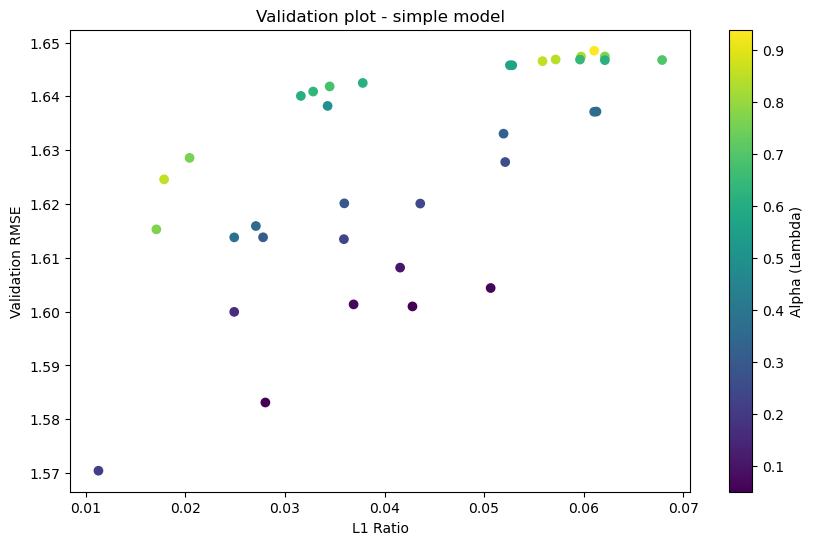

In [67]:
#Plot the rmse with ratio and and alphas

# Extract relevant fields from cv_results_
alphas = cv_result_uden_egne_opdateret_data_samme_lamb_35['param_elasticnet__alpha'].data  # Extract lambda values
l1_ratios = cv_result_uden_egne_opdateret_data_samme_lamb_35['param_elasticnet__l1_ratio'].data  # Extract l1 ratio values
mean_test_scores = cv_result_uden_egne_opdateret_data_samme_lamb_35['mean_test_score']  # Extract mean test scores (negative MSE)

# Convert negative MSE to RMSE
rmse_scores = np.sqrt(-mean_test_scores)

# Plotting the validation curve
plt.figure(figsize=(10, 6))
plt.scatter(alphas, rmse_scores, c=l1_ratios, cmap='viridis', marker='o')
plt.colorbar(label='Alpha (Lambda)')
plt.title('Validation plot - simple model')
plt.xlabel('L1 Ratio')
plt.ylabel('Validation RMSE')
plt.show()

In [71]:
# Find the index of the best score (which corresponds to the lowest RMSE)


#PULL CS_RESULt from the run you want

best_index = np.argmax(cv_result_uden_egne_opdateret_data_samme_lamb_35['mean_test_score'])  # mean_test_score is negative MSE

# Retrieve the optimal alpha (lambda) and l1_ratio
optimal_alpha = cv_result_uden_egne_opdateret_data_samme_lamb_35['param_elasticnet__alpha'][best_index]
optimal_l1_ratio = cv_result_uden_egne_opdateret_data_samme_lamb_35['param_elasticnet__l1_ratio'][best_index]

# Convert the best mean_test_score (which is negative MSE) to positive RMSE
optimal_rmse = np.sqrt(-cv_result_uden_egne_opdateret_data_samme_lamb_35['mean_test_score'][best_index])

print(f"Optimal Alpha (Lambda) for cv_result_uden_egne_opdateret_data_samme_lamb_35: {optimal_alpha}")
print(f"Optimal L1 Ratio for cv_result_uden_egne_opdateret_data_samme_lamb_35: {optimal_l1_ratio}")
print(f"Optimal RMSE for cv_result_uden_egne_opdateret_data_samme_lamb_35: {optimal_rmse}")


Optimal Alpha (Lambda) for cv_result_uden_egne_opdateret_data_samme_lamb_35: 0.011264005755556604
Optimal L1 Ratio for cv_result_uden_egne_opdateret_data_samme_lamb_35: 0.21212121212121213
Optimal RMSE for cv_result_uden_egne_opdateret_data_samme_lamb_35: 1.5704378484403465


In [55]:
# Refit the model on the entire development dataset with the optimal hyperparameters from run 4
uden_egne_opdateret_data_samme_lamb_35 = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1_ratio, random_state=161193)
uden_egne_opdateret_data_samme_lamb_35_el = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False), 
    StandardScaler(),
    uden_egne_opdateret_data_samme_lamb_35
)

# Fit the model to the entire development dataset
uden_egne_opdateret_data_samme_lamb_35_el.fit(X_dev, y_dev)

# Apply the model to the test data
y_test_uden_egne = uden_egne_opdateret_data_samme_lamb_35_el.predict(X_test)

# Evaluate performance on the test data
test_rmse_uden_egne = np.sqrt(mse(y_test, y_test_uden_egne))
print(f"Test RMSE for the model from uden_egne_opdateret_data_samme_lamb_35: {test_rmse_uden_egne}")

Test RMSE for the model from run 11: 2.1416637451131404


In [57]:
r_squared = r2_score(y_test, y_test_uden_egne)
print(f"R-squared: {r_squared}")

R-squared: 0.6343708791573404
